In [1]:
from numpy import *
import operator
import os

In [2]:
def createDataSet(): #创建数据集和标签
    groups = array([[1.0,1.1],[1.0,1.0],[0,0],[0,1.0]])
    labels = ['A','A','B','B']
    return groups,labels

In [3]:
groups,labels=createDataSet()
groups,labels

(array([[1. , 1.1],
        [1. , 1. ],
        [0. , 0. ],
        [0. , 1. ]]),
 ['A', 'A', 'B', 'B'])

 ### 基于欧氏距离的knn算法

In [4]:
def classify0(inX,dataSet,labels,k): 
    """
    参数: 
    - inX: 用于分类的输入向量
    - dataSet: 输入的训练样本集
    - labels: 样本数据的类标签向量
    - k: 用于选择最近邻居的数目
    """
    dataSetsize = dataSet.shape[0]
    diffMat = tile(inX,(dataSetsize,1))-dataSet
    sqDiffMat = diffMat**2
    sqDistance = sqDiffMat.sum(axis=1) #按行求和
    distances = sqDistance**0.5
    sortedDistIndices = distances.argsort() #将distance按从小到大排序，并返回下标
    classCount={}
    for i in range(k):
        voteIlabel = labels[sortedDistIndices[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0)+1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0] #返回发生频率最高的元素标签

In [5]:
classify0([0,0],groups,labels,2)

'B'

In [6]:
from numpy import *
linalg.norm(array([3,3,3])-array([1,1,1]),ord=1)  #曼哈顿距离

6.0

### 基于马氏距离的knn算法
马氏距离有很多优点。它不受量纲的影响，两点之间的马氏距离与原始数据的测量单位无关；由标准化数据和中心化数据(即原始数据与均值之差）计算出的二点之间的马氏距离相同。马氏距离还可以排除变量之间的相关性的干扰。它的缺点是夸大了变化微小的变量的作用。

In [7]:
def classify_M(inX,dataSet,labels,k): 
    """
    参数: 
    - inX: 用于分类的输入向量
    - dataSet: 输入的训练样本集
    - labels: 样本数据的类标签向量
    - k: 用于选择最近邻居的数目
    """
    dataSetsize = dataSet.shape[0]
    distances=[]
    for i in range(dataSetsize):
        x = array(dataSet)
        xt=x.T
        D=cov(xt)
        invD=linalg.inv(D)
        tp=inX-dataSet[i]
        distances.append(sqrt(dot(dot(tp,invD),tp.T)))   #马氏距离
        
    sortedDistIndices = array(distances).argsort() #将distance按从小到大排序，并返回下标
    classCount={}
    for i in range(k):
        voteIlabel = labels[sortedDistIndices[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0)+1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0] #返回发生频率最高的元素标签


In [8]:
classify0([0,0],groups,labels,2)

'B'

 ### wk_NNC算法
 wk-NNC算法是对经典knn算法的改进，这种方法是对k个近邻的样本按照他们距离待分类样本的远近给一个权值w：
w^i=(h^k-h^i)/(h^k-h^l)  
w^i是第i个近邻的权值，其中h^i是待测样本距离第i个近邻的距离。

In [9]:
def knn_W(inX, dataSet, labels, k):
    dataSetSize = dataSet.shape[0]
    diffMat = tile(inX, (dataSetSize,1)) - dataSet  

    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1) 
    distances = sqDistances**0.5
    sortedDistIndicies = distances.argsort()        
    classCount={}   
    w=[]     
    for i in range(k):
        w.append((distances[sortedDistIndicies[k-1]]-distances[sortedDistIndicies[i]]\
        )/(distances[sortedDistIndicies[k-1]]-distances[sortedDistIndicies[0]]))
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + w[i]
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [10]:
knn_W([0,0],groups,labels,2)

'B'

### knnm算法
knnm算法运用了训练样本中的每一个模式，对训练样本的每个类clip_image008，

1 ≤ i ≤ c，在每一个类中找出距离测试样本距离最近的k个近邻clip_image010，假设这k个近邻的均值为clip_image012，同样的，i从1到c变化，我们得到clip_image014，如果clip_image016是M当中距离测试样本最近的，则测试样本属于clip_image018类。

       如下图所示，对于一个两类的问题，每个类选三个近邻，类clip_image020用*表示，类clip_image022用o表示，“Y”是测试样本，则Y属于clip_image022[1]类。
       

In [11]:
def knn_M(inX, dataSet, labels, k):
    dataSetSize = dataSet.shape[0]
    diffMat = tile(inX, (dataSetSize, 1)) - dataSet   #tile repeat inX to (dataSetSize,1)
    sqDiffMat = diffMat ** 2
    sqDistances = sqDiffMat.sum(axis=1)  #sum per row
    distances = sqDistances ** 0.5
    sortedDistIndicies = distances.argsort()
    classCount={}
    classNum={}
    i=0
    while i<dataSetSize:
        voteIlabel = labels[sortedDistIndicies[i]]
        if sum(classNum)==10*k:
            break
        elif classNum.get(voteIlabel,0)==k:
            i += 1
        else:
            classCount[voteIlabel] = classCount.get(voteIlabel,0) \
                                     + distances[sortedDistIndicies[i]]
            classNum[voteIlabel]=classNum.get(voteIlabel,0)+1
            i += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1))
    return sortedClassCount[0][0]

In [12]:
knn_M([0,0],groups,labels,2)

'B'

### 手写识别系统

准备数据：将图像转换为测试向量

In [13]:
def img2vector(filename):
    returnVect = zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j]= int(lineStr[j])
    return returnVect

In [14]:
testVect=img2vector('testDigits/0_0.txt')
testVect[0,0:31]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
def handWritingClassTest():
    hwLabels = [] # 样本数据的类标签列表
    trainingFileList = os.listdir('trainingDigits')  # 样本数据文件列表
    m = len(trainingFileList)
    print("trainingDigits has %d files"%m)
    trainingMat = zeros((m,1024)) # 初始化样本数据矩阵（M*1024）
    # 依次读取所有样本数据到数据矩阵
    for i in range(m):
        fileNameStr = trainingFileList[i] # 提取文件名中的数字
        fileStr = fileNameStr.split('.')[0]
        classNumStr= int(fileStr.split('_')[0])
        hwLabels.append(classNumStr)
        # 将样本数据存入矩阵
        trainingMat[i,:]=img2vector('./trainingDigits/%s'%fileNameStr)
    testFileList=os.listdir('./testDigits') # 循环读取测试数据
    errorCount = 0.0   # 初始化错误率
    mTest = len(testFileList)
    print("testDigits has %d files"%mTest)
    k=3
    # 循环测试每个测试数据文件
    for i in range(mTest):
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr= int(fileStr.split('_')[0])
        # 提取数据向量
        vectorUnderTest = img2vector('./testDigits/%s'%fileNameStr)
        # 对数据文件进行分类
        classifierResult=knn_W(vectorUnderTest,trainingMat,hwLabels,k)
        # 打印 K 近邻算法分类结果和真实的分类
        print('when the file is:%d,the k is:%d,the classifier came back with :%d,the real answer is:%d'%(i+1,k,classifierResult,classNumStr))
         # 判断K 近邻算法结果是否准确
        if (classifierResult != classNumStr):
            errorCount += 1.0
    #计算并打印错误率
    print("the total number of errors is:%d"%errorCount)
    print("the total error rate is:%f"%(errorCount/float(mTest)))
    

In [16]:
hwLabels = {} # 样本数据的类标签列表
# trainingFileList = os.listdir('trainingDigits')  # 样本数据文件列表
# m = len(trainingFileList)
# print("trainingDigits has %d files"%m)
testFileList=os.listdir('./testDigits') # 循环读取测试数据
m = len(testFileList)
print("testDigits has %d files"%m)
for i in range(m):
#         fileNameStr = trainingFileList[i] # 提取文件名中的数字
        fileNameStr = testFileList[i] # 提取文件名中的数字
        fileStr = fileNameStr.split('.')[0]
        classNumStr= int(fileStr.split('_')[0])
        if classNumStr not in hwLabels.keys():
            hwLabels[classNumStr]=0
        hwLabels[classNumStr]+=1
print(hwLabels)

testDigits has 946 files
{0: 87, 1: 97, 2: 92, 3: 85, 4: 114, 5: 108, 6: 87, 7: 96, 8: 91, 9: 89}


In [17]:
fr=open("./testDigits/%s"%testFileList[0])
line=fr.readlines()
print(len(line))

32


In [18]:
handWritingClassTest()

trainingDigits has 1934 files
testDigits has 946 files
when the file is:1,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:2,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:3,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:4,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:5,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:6,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:7,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:8,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:9,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:10,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:11,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:12

C:\Users\Zero\AppData\Local\Temp/ipykernel_2516/373104347.py:12: RuntimeWarning: invalid value encountered in double_scalars
  w.append((distances[sortedDistIndicies[k-1]]-distances[sortedDistIndicies[i]]\


when the file is:61,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:62,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:63,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:64,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:65,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:66,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:67,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:68,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:69,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:70,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:71,the k is:3,the classifier came back with :0,the real answer is:0
when the file is:72,the k is:3,the classifier came back with :0,t

when the file is:167,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:168,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:169,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:170,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:171,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:172,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:173,the k is:3,the classifier came back with :7,the real answer is:1
when the file is:174,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:175,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:176,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:177,the k is:3,the classifier came back with :1,the real answer is:1
when the file is:178,the k is:3,the classifier came ba

when the file is:264,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:265,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:266,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:267,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:268,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:269,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:270,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:271,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:272,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:273,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:274,the k is:3,the classifier came back with :2,the real answer is:2
when the file is:275,the k is:3,the classifier came ba

when the file is:361,the k is:3,the classifier came back with :3,the real answer is:3
when the file is:362,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:363,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:364,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:365,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:366,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:367,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:368,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:369,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:370,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:371,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:372,the k is:3,the classifier came ba

when the file is:461,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:462,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:463,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:464,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:465,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:466,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:467,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:468,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:469,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:470,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:471,the k is:3,the classifier came back with :4,the real answer is:4
when the file is:472,the k is:3,the classifier came ba

when the file is:567,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:568,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:569,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:570,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:571,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:572,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:573,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:574,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:575,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:576,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:577,the k is:3,the classifier came back with :5,the real answer is:5
when the file is:578,the k is:3,the classifier came ba

when the file is:664,the k is:3,the classifier came back with :6,the real answer is:6
when the file is:665,the k is:3,the classifier came back with :6,the real answer is:6
when the file is:666,the k is:3,the classifier came back with :6,the real answer is:6
when the file is:667,the k is:3,the classifier came back with :6,the real answer is:6
when the file is:668,the k is:3,the classifier came back with :6,the real answer is:6
when the file is:669,the k is:3,the classifier came back with :6,the real answer is:6
when the file is:670,the k is:3,the classifier came back with :6,the real answer is:6
when the file is:671,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:672,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:673,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:674,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:675,the k is:3,the classifier came ba

when the file is:762,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:763,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:764,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:765,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:766,the k is:3,the classifier came back with :7,the real answer is:7
when the file is:767,the k is:3,the classifier came back with :8,the real answer is:8
when the file is:768,the k is:3,the classifier came back with :8,the real answer is:8
when the file is:769,the k is:3,the classifier came back with :8,the real answer is:8
when the file is:770,the k is:3,the classifier came back with :6,the real answer is:8
when the file is:771,the k is:3,the classifier came back with :8,the real answer is:8
when the file is:772,the k is:3,the classifier came back with :8,the real answer is:8
when the file is:773,the k is:3,the classifier came ba

when the file is:870,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:871,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:872,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:873,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:874,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:875,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:876,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:877,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:878,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:879,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:880,the k is:3,the classifier came back with :9,the real answer is:9
when the file is:881,the k is:3,the classifier came ba

### 线上交友

将文本记录到转换NumPy的解析程序

In [19]:
def file2matrix(filename):
    fr = open(filename)
    numberOfLines = len(fr.readlines()) #get the number of lines in the file
    returnMat = zeros((numberOfLines,3))
    #prepare matrix to return
    classLabelVector = [] #prepare labels return
    index = 0
    fr=open(filename)
    for line in fr.readlines():
        line = line.strip() #remove off ‘\n’
        listFromLine = line.split('\t')
        returnMat[index,:] = listFromLine[0:3]
        classLabelVector.append(int(listFromLine[-1])) #for datingTestSet.txt
#         classLabelVector.append(listFromLine[-1])
        index += 1
    return returnMat,classLabelVector

In [20]:
datingDataMat,datingLabels = file2matrix('datingTestSet.txt')

In [21]:
datingDataMat

array([[4.0920000e+04, 8.3269760e+00, 9.5395200e-01],
       [1.4488000e+04, 7.1534690e+00, 1.6739040e+00],
       [2.6052000e+04, 1.4418710e+00, 8.0512400e-01],
       ...,
       [2.6575000e+04, 1.0650102e+01, 8.6662700e-01],
       [4.8111000e+04, 9.1345280e+00, 7.2804500e-01],
       [4.3757000e+04, 7.8826010e+00, 1.3324460e+00]])

In [22]:
datingLabels[0:20]

[3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3]

### 创建散点图

D:\ProgramFiles\python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ProgramFiles\python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ProgramFiles\python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33719 (\N{CJK UNIFIED IDEOGRAPH-83B7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ProgramFiles\python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ProgramFiles\python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_

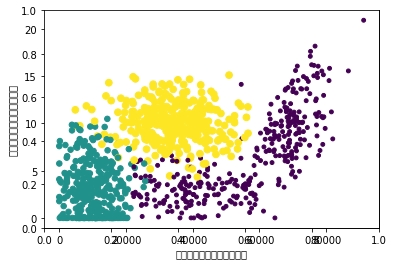

In [23]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.xlabel("每年获得的飞行常客里程数")
plt.ylabel("玩视频游戏所耗时间百分比")
# plt.xlabel("玩视频游戏所耗时间百分比")
# plt.ylabel("每周所消费的冰淇淋公升数")
ax = fig.add_subplot(1,1,1)
# ax.scatter(datingDataMat[:,1],datingDataMat[:,2])
ax.scatter(datingDataMat[:,0],datingDataMat[:,1],15.0*array(datingLabels),15*array(datingLabels))
plt.show()

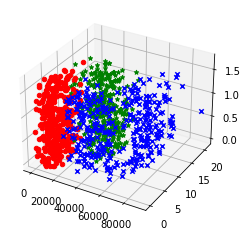

In [24]:
datingDataMat, datingLabels = file2matrix('datingTestSet.txt')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
num = len(datingDataMat)
for i in range(num):
    if datingLabels[i] == 1:
        ax.scatter(datingDataMat[i][0], datingDataMat[i][1], datingDataMat[i][2], c='b', marker='x')
    elif datingLabels[i] == 2:
        ax.scatter(datingDataMat[i][0], datingDataMat[i][1], datingDataMat[i][2], c='r', marker='o')
    elif datingLabels[i] == 3:
        ax.scatter(datingDataMat[i][0], datingDataMat[i][1], datingDataMat[i][2], c='g', marker='*')
plt.show()

### 归一化数值
newvalue = (oldvalue-min)/(max-min)

In [25]:
def autoNorm(dataSet):
    minVals = dataSet.min(0)  #按列求最小值
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = zeros(shape(dataSet))
    m = dataSet.shape[0]
    normDataSet = dataSet - tile(minVals, (m,1))
    normDataSet = normDataSet/tile(ranges, (m,1))
    #element wise divide
    return normDataSet, ranges, minVals


In [26]:
normMat,ranges,minVals = autoNorm(datingDataMat)
normMat

array([[0.44832535, 0.39805139, 0.56233353],
       [0.15873259, 0.34195467, 0.98724416],
       [0.28542943, 0.06892523, 0.47449629],
       ...,
       [0.29115949, 0.50910294, 0.51079493],
       [0.52711097, 0.43665451, 0.4290048 ],
       [0.47940793, 0.3768091 , 0.78571804]])

In [27]:
minVals,type(minVals)

(array([0.      , 0.      , 0.001156]), numpy.ndarray)

In [28]:
a=array([1000,10,0.5])
minVals-a

array([-1.00000e+03, -1.00000e+01, -4.98844e-01])

### 测试算法：作为完整程序验证分类器

In [29]:
def datingClassTest():
    hoRatio = 0.50 #hold out 10% 交叉验证
    datingDataMat,datingLabels = file2matrix('datingTestSet.txt') #load data set from file
    normMat, ranges, minVals = autoNorm(datingDataMat) #归一化
    m = normMat.shape[0]
    numTestVecs = int(m*hoRatio)
    errorCount = 0.0
    k=6
    for i in range(numTestVecs):
        classifierResult =knn_W(normMat[i,:],normMat[numTestVecs:m,:],datingLabels[numTestVecs:m],k)
        print('the testdatasets is {},the k is {},the classifier came back with: {}, the real answer is:{}'.format(hoRatio,k,classifierResult, datingLabels[i]))
        if (classifierResult != datingLabels[i]): 
            errorCount += 1.0 #计算分类错误率
    print('the total error rate is: %f'%(errorCount/float(numTestVecs))) 
     

In [30]:
datingClassTest()

the testdatasets is 0.5,the k is 6,the classifier came back with: 3, the real answer is:3
the testdatasets is 0.5,the k is 6,the classifier came back with: 2, the real answer is:2
the testdatasets is 0.5,the k is 6,the classifier came back with: 1, the real answer is:1
the testdatasets is 0.5,the k is 6,the classifier came back with: 1, the real answer is:1
the testdatasets is 0.5,the k is 6,the classifier came back with: 1, the real answer is:1
the testdatasets is 0.5,the k is 6,the classifier came back with: 1, the real answer is:1
the testdatasets is 0.5,the k is 6,the classifier came back with: 3, the real answer is:3
the testdatasets is 0.5,the k is 6,the classifier came back with: 3, the real answer is:3
the testdatasets is 0.5,the k is 6,the classifier came back with: 1, the real answer is:1
the testdatasets is 0.5,the k is 6,the classifier came back with: 3, the real answer is:3
the testdatasets is 0.5,the k is 6,the classifier came back with: 1, the real answer is:1
the testda

### 使用算法：构建完整可用系统

In [31]:
def classifyPerson():
    ffMiles = float(input("frequent flier miles earned per year?"))
    percentTags = float(input("percentage of time spent playing video games?"))
    iceCreams = float(input("liters of ice cream consumed per year?"))
    datingDataMat,datingLabels = file2matrix('datingTestSet2.txt')
    normMat,ranges,minVals = autoNorm(datingDataMat)
    inArr = array([ffMiles,percentTags,iceCreams])
    classifierResult = classify0((inArr-minVals)/ranges,normMat,datingLabels,4)
    print("You probably like this person: in %s"% classifierResult)

In [ ]:
classifyPerson()